In [7]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [8]:
csv_files_auto = glob.glob("./data/auto/*response_times.csv")

dfs_auto = [pd.read_csv(file, usecols=["response_time_ms", "gpu_used"]) for file in csv_files_auto]

# assign rates
cpu_rate = 0.000038  # per second
gpu_rate = 0.000133  # per second

# Auto Cost Calculation
results = []

for df in dfs_auto:
    # df = df.copy()
    df["response_time_s"] = df["response_time_ms"] / 1000
    df["cost"] = df.apply(
        lambda row: row["response_time_s"] * (cpu_rate if not row["gpu_used"] else gpu_rate),
        axis=1
    )

    grouped = df.groupby("gpu_used")["response_time_s"].sum()
    results.append(grouped)

seconds_per_execution_mode_per_run_auto = pd.DataFrame(results).fillna(0)

seconds_per_execution_mode_per_run_auto += 30

cost_per_execution_mode_per_run_auto = pd.DataFrame({
    False: seconds_per_execution_mode_per_run_auto[False] * cpu_rate,
    True: seconds_per_execution_mode_per_run_auto[True] * gpu_rate,
})

mean_cost_per_execution_mode_auto = cost_per_execution_mode_per_run_auto.mean()

cost_auto = mean_cost_per_execution_mode_auto.sum()

print(cost_auto)


0.02115514550962448


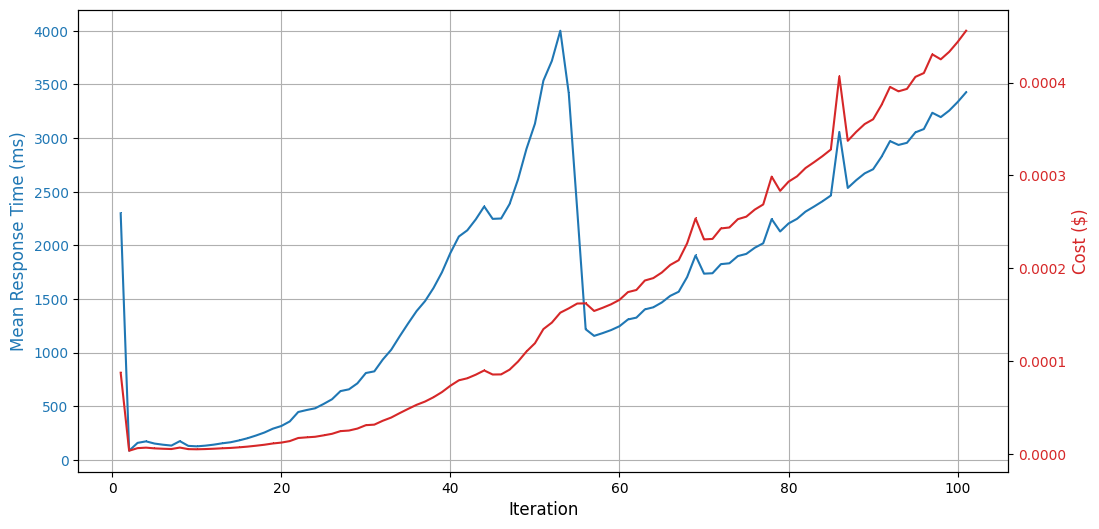

In [9]:
responses_auto = pd.concat([df['response_time_ms'] for df in dfs_auto], axis=1)
responses_auto.columns = [f"run_{i + 1}" for i in range(len(dfs_auto))]

responses_means = pd.DataFrame({
    "iteration": range(1, len(responses_auto) + 1),
    "mean_response_time": responses_auto.mean(axis=1).values
})

costs_auto = pd.concat([df['cost'] for df in dfs_auto], axis=1)
costs_auto.columns = [f"run_{i + 1}" for i in range(len(dfs_auto))]

cost_means = pd.DataFrame({
    "iteration": range(1, len(costs_auto) + 1),
    "mean_cost": costs_auto.mean(axis=1).values
})

# plot with iteration on x axis and mean_response_time on y axis
# First y-axis: response time
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(responses_means["iteration"], responses_means["mean_response_time"], color="tab:blue", marker=',')
ax1.set_xlabel("Iteration", fontsize=12)
ax1.set_ylabel("Mean Response Time (ms)", fontsize=12, color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.grid(True)

# Second y-axis: cost
ax2 = ax1.twinx()
ax2.plot(cost_means["iteration"], cost_means["mean_cost"], color="tab:red", marker=',')
ax2.set_ylabel("Cost ($)", fontsize=12, color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")

plt.show()


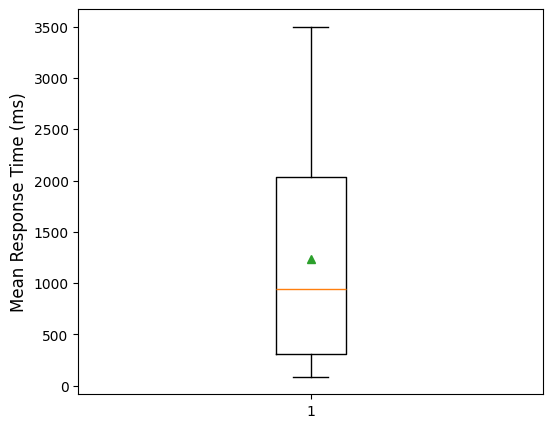

In [10]:
# GPU Boxplot
csv_files_gpu = glob.glob("./data/gpu/*response_times.csv")

dfs_gpu = [pd.read_csv(file, usecols=["response_time_ms"]) for file in csv_files_gpu]

combined_gpu = pd.concat(dfs_gpu, axis=1)
combined_gpu.columns = [f"run_{i + 1}" for i in range(len(dfs_gpu))]

response_time_sum_gpu = combined_gpu.mean(axis=1).sum() / 1000

# Compute row means, skipping the first row (cold start)
row_means_without_coldstart_gpu = combined_gpu.iloc[1:].mean(axis=1)

# Create a boxplot of row means
plt.figure(figsize=(6,5))
plt.boxplot(row_means_without_coldstart_gpu, showmeans=True)

# plt.title("Boxplot of Mean Response Times per Request (without cold start)", fontsize=14)
plt.ylabel("Mean Response Time (ms)", fontsize=12)

plt.show()

In [34]:
# GPU Cost Calculation

results = []

for df in dfs_gpu:
    df = df.copy()
    df["response_time_ms"] = df["response_time_ms"].interpolate()

    df["response_time_s"] = df["response_time_ms"] / 1000

    sum = df["response_time_s"].sum()
    results.append(sum)

seconds_gpu = pd.DataFrame(results).fillna(0)
seconds_gpu += 30

cost_per_run_gpu = seconds_gpu * gpu_rate
mean_cost_gpu = cost_per_run_gpu.mean()

cost_gpu = mean_cost_gpu.sum()

print(cost_gpu)

0.021735717252564433


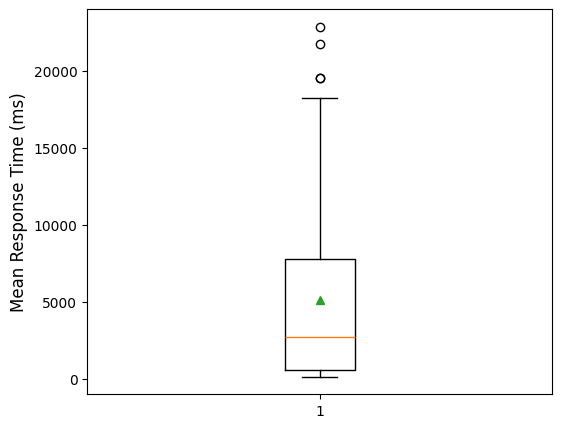

In [26]:
# CPU Boxplot
csv_files_cpu = glob.glob("./data/cpu/*response_times.csv")

dfs_cpu = [pd.read_csv(file, usecols=["response_time_ms"]) for file in csv_files_cpu]

combined_cpu = pd.concat(dfs_cpu, axis=1)
combined_cpu.columns = [f"run_{i + 1}" for i in range(len(dfs_cpu))]

# Compute row means, skipping the first row (cold start)
row_means_without_coldstart_cpu = combined_cpu.iloc[1:].mean(axis=1)

# filter out NaN values
row_means_without_coldstart_cpu = row_means_without_coldstart_cpu.dropna()

# Create a boxplot of row means
plt.figure(figsize=(6,5))
plt.boxplot(row_means_without_coldstart_cpu, showmeans=True)

# Add title and labels
# plt.title("Boxplot of Mean Response Times per Request (without cold start)", fontsize=14)
plt.ylabel("Mean Response Time (ms)", fontsize=12)

plt.show()


In [33]:
# CPU Cost Calculation

results = []

for df in dfs_cpu:
    df = df.copy()
    df["response_time_ms"] = df["response_time_ms"].interpolate()
    df["response_time_s"] = df["response_time_ms"] / 1000

    sum = df["response_time_s"].sum()
    results.append(sum)

seconds_cpu = pd.DataFrame(results).fillna(0)
seconds_cpu += 30

cost_per_run_cpu = seconds_cpu * cpu_rate
mean_cost_cpu = cost_per_run_cpu.mean()

cost_cpu = mean_cost_cpu.sum()

print(cost_cpu)

0.021061521062469484


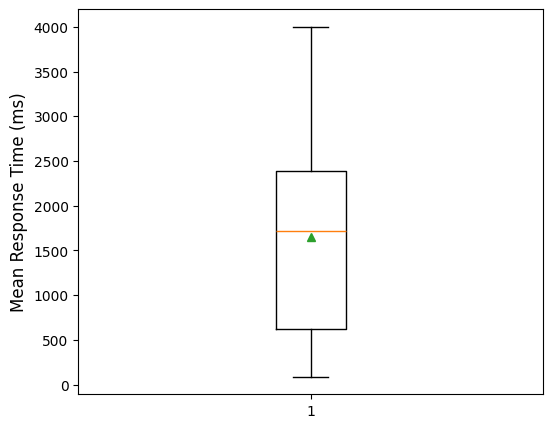

In [28]:
# Auto Boxplot

# Compute row means, skipping the first row (cold start)
row_means_without_coldstart_auto = responses_auto.iloc[1:].mean(axis=1)

# Create a boxplot of row means
plt.figure(figsize=(6,5))
plt.boxplot(row_means_without_coldstart_auto, showmeans=True)

# Add title and labels
# plt.title("Boxplot of Mean Response Times per Request (without cold start)", fontsize=14)
plt.ylabel("Mean Response Time (ms)", fontsize=12)

plt.show()

[np.float64(0.021061521062469484), np.float64(0.021735717252564433), np.float64(0.02115514550962448)]


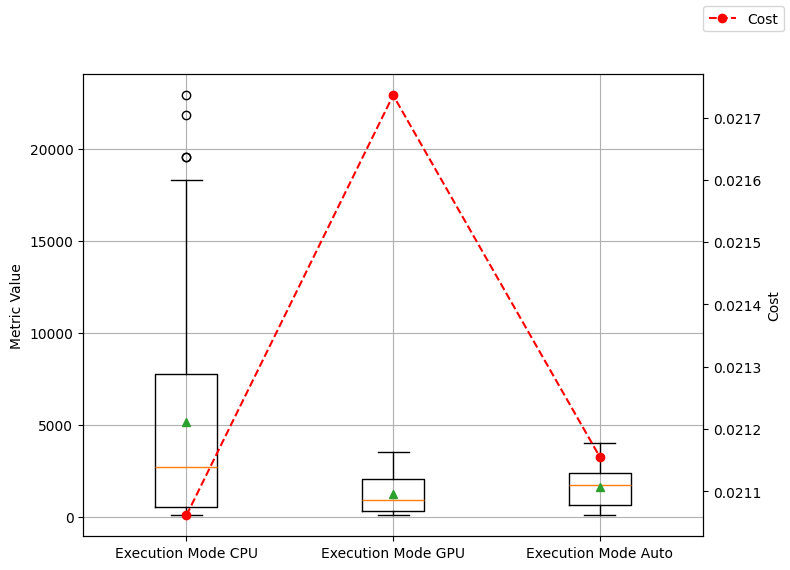

In [35]:
# Combine both CPU and GPU data for comparison

data = [row_means_without_coldstart_cpu, row_means_without_coldstart_gpu, row_means_without_coldstart_auto]

fig, ax1 = plt.subplots(figsize=(8,6))

# Boxplots on left y-axis
ax1.boxplot(
    data,
    tick_labels=["Execution Mode CPU", "Execution Mode GPU", "Execution Mode Auto"],
    showmeans=True
)
ax1.set_ylabel("Metric Value")

costs = [cost_cpu, cost_gpu, cost_auto]

print(costs)

positions = [1, 2, 3]


# Add a second axis for costs
ax2 = ax1.twinx()
# positions = [1, 2, 3]
ax2.plot(positions, costs, "ro--", label="Cost")  # red dotted line with markers
ax2.set_ylabel("Cost")

ax1.grid(True)
fig.legend()
plt.show()


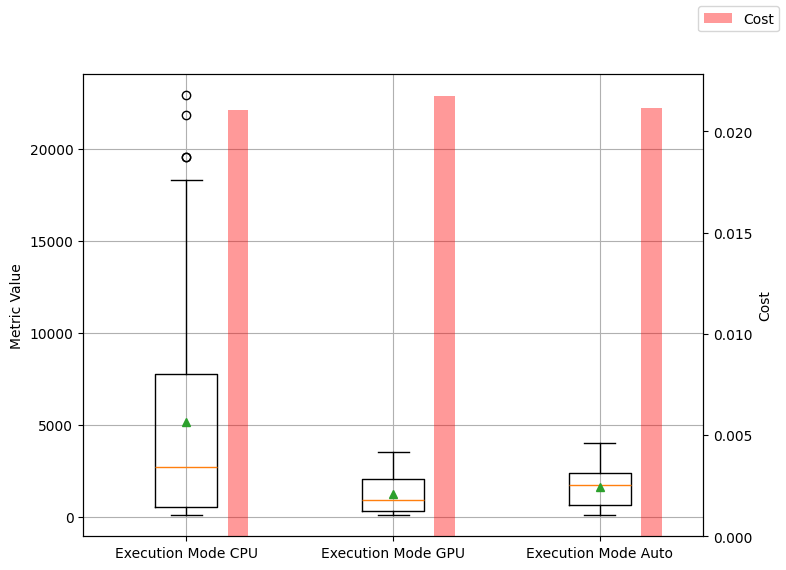

In [36]:
fig, ax1 = plt.subplots(figsize=(8,6))

positions = [1, 2, 3]
ax1.boxplot(
    data,
    tick_labels=["Execution Mode CPU", "Execution Mode GPU", "Execution Mode Auto"],
    showmeans=True,
    positions=positions
)
ax1.set_ylabel("Metric Value")

# Second axis for costs
ax2 = ax1.twinx()

# Shifted & thinner bars
bar_width = 0.1
offset = 0.25  # shift to the right
ax2.bar(
    [p + offset for p in positions],
    costs,
    width=bar_width,
    color="red",
    alpha=0.4,
    label="Cost"
)

ax2.set_ylabel("Cost")
ax1.grid(True)
fig.legend()
plt.show()

In [32]:
# Calculate and print summary statistics

# mean of first values
auto_coldstart = responses_auto.iloc[0].mean()
gpu_coldstart = combined_gpu.iloc[0].mean()
cpu_coldstart = combined_cpu.iloc[0].mean()


print(f"Auto Cold Start Mean: {auto_coldstart:.2f} ms")
print(f"GPU Cold Start Mean: {gpu_coldstart:.2f} ms")
print(f"CPU Cold Start Mean: {cpu_coldstart:.2f} ms")

Auto Cold Start Mean: 2299.18 ms
GPU Cold Start Mean: 9811.24 ms
CPU Cold Start Mean: 1724.49 ms
